In [0]:
%tensorflow_version 2.x
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

# Generator
입력을 16\*16 크기의 128 채널 특성맵으로 변환, Conv2D 거친 후, 32\*32로 업샘플링

In [5]:
gen_input = Input(shape=(latent_dim,), name='gen_input')

x = Dense(128 * 16 * 16)(gen_input)
x = LeakyReLU()(x)
x = Reshape((16,16,128))(x)

x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = Model(gen_input, x, name='Gen')
generator.summary()

Model: "Gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_input (InputLayer)       [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       1048832 

# Discriminator

In [7]:
dis_input = Input(shape=(height, width, channels))
x = Conv2D(128, 3)(dis_input)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)

x = Dropout(0.4)(x)

x = Dense(1, activation='sigmoid')(x)

discriminator = Model(dis_input, x, name='Dis')
discriminator.summary()

discriminator_optimizer = RMSprop(
    lr=0.0008,
    clipvalue=1.0,
    decay=1e-8) #그래디언트 클래핑과 학습률 감쇠 적용
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "Dis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6, 6, 128)         0       

# Create Adversarial Network

In [0]:
discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

# Train

In [0]:
(x_train, y_train), (_,_) = tensorflow.keras.datasets.cifar10.load_data()

In [0]:
x_train = x_train[y_train.flatten() == 6] #개구리 이미지 선택
x_train = x_train.reshape((x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

In [0]:
iterations = 10000
batch_size = 20

In [15]:
start = 0
fakes = []
reals = []
for step in range(1, iterations+1):
  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
  generated_images = generator.predict(random_latent_vectors)

  stop = start + batch_size
  real_images = x_train[start: stop]
  
  combined_images = np.concatenate([generated_images, real_images])
  labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
  labels += 0.05 * np.random.random(labels.shape) # 레이블에 랜덤 노이즈 추가(중요!!!)
  
  d_loss = discriminator.train_on_batch(combined_images, labels)  #Discriminator 훈련

  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
  misleading_targets = np.zeros((batch_size,1)) #모두 진짜 이미지라는 가짜 정답표 생성
  
  a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)  #Generator 훈련

  start += batch_size
  if start > len(x_train) - batch_size:
    start = 0
  if step % 100 == 0:
    print('batch step:',step,'/',iterations)
    print('판별자 손실 :', d_loss)
    print('적대적 손실 :', a_loss)

    img = generated_images[0]
    fakes.append(img)

    img = real_images[stop-1]
    reals.append(img)

판별자 손실 : 0.6884089
적대적 손실 : 0.78581876
판별자 손실 : 0.7254561
적대적 손실 : 0.79443187
판별자 손실 : 0.66669476
적대적 손실 : 0.86504734
판별자 손실 : 0.657294
적대적 손실 : 1.1110656
판별자 손실 : 0.6345665
적대적 손실 : 0.8948223
판별자 손실 : 0.6686431
적대적 손실 : 1.0464586
판별자 손실 : 0.69026357
적대적 손실 : 0.83597773
판별자 손실 : 0.69046134
적대적 손실 : 0.7862955
판별자 손실 : 0.637687
적대적 손실 : 0.6928344
판별자 손실 : 0.6745584
적대적 손실 : 0.8186556
판별자 손실 : 0.6826018
적대적 손실 : 0.7851238
판별자 손실 : 0.7562997
적대적 손실 : 0.8532468
판별자 손실 : 0.68630034
적대적 손실 : 0.8701741
판별자 손실 : 0.6792716
적대적 손실 : 0.7540575


# Visualize Result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

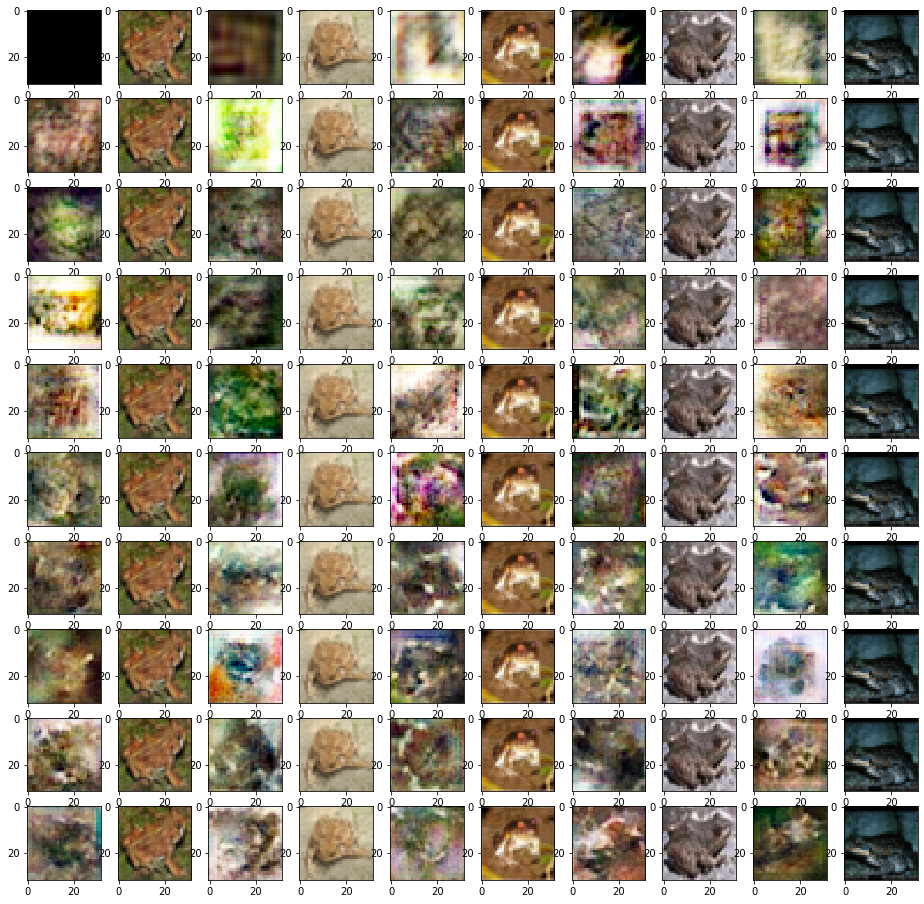

In [27]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(16, 16))
columns = 10
rows = 10

for i in range(1, columns*rows +1):
  if i%2==0:
    img = reals[i-1]
  else:
    img = fakes[i-1]
  fig.add_subplot(rows, columns, i)
  plt.imshow(img)
plt.show()